In [1]:
# Import the relevant modules
import os
import sys
import glob

# Import third party modules
import numpy as np
import xarray as xr
import regionmask
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import dictionaries_em as dicts

In [3]:
# Load in the onshore wind power data
files = glob.glob(
    os.path.join(dicts.clearheads_dir, "NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc")
)

# Load the file
ds = xr.open_dataset(files[0], chunks={"time": 100})

# Print tyhe dataset
print(ds)

<xarray.Dataset>
Dimensions:                            (time: 622392, NUTS: 13)
Dimensions without coordinates: time, NUTS
Data variables:
    time_in_hours_from_first_jan_1950  (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    NUTS_keys                          (NUTS) object dask.array<chunksize=(13,), meta=np.ndarray>
    timeseries_data                    (NUTS, time) float32 dask.array<chunksize=(13, 100), meta=np.ndarray>


In [4]:
# Print the nuts key values
print(ds.NUTS_keys.values)

['UK' 'IE' 'NL' 'FR' 'BE' 'DE' 'DK' 'NO' 'SE' 'ES' 'LI' 'LT' 'AT']


In [5]:
nuts_keys = ds.NUTS_keys.values

In [6]:
# Load in the shapefile
NUTS_shapefile = gpd.read_file("shapefiles/NUTS/NUTS_RG_10M_2021_4326.shp")

# Look at the head of the file
NUTS_shapefile.head()

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,BG423,3,BG,Pazardzhik,Пазарджик,3.0,2,3,BG423,"POLYGON ((24.42101 42.55306, 24.41032 42.46950..."
1,BG424,3,BG,Smolyan,Смолян,3.0,3,3,BG424,"POLYGON ((25.07422 41.79348, 25.05851 41.75177..."
2,BG425,3,BG,Kardzhali,Кърджали,3.0,3,3,BG425,"POLYGON ((25.94863 41.32034, 25.90644 41.30757..."
3,CH011,3,CH,Vaud,Vaud,3.0,2,3,CH011,"MULTIPOLYGON (((6.86623 46.90929, 6.89621 46.9..."
4,CH012,3,CH,Valais,Valais,3.0,2,3,CH012,"POLYGON ((8.47767 46.52760, 8.39953 46.48872, ..."


In [7]:
# Using the dictionary for country codes, constrain the shapefile to only include those in the country codes
NUTS_shapefile = NUTS_shapefile[NUTS_shapefile["CNTR_CODE"].isin(nuts_keys)]

# Constrain to onlty national level
NUTS_shapefile = NUTS_shapefile[NUTS_shapefile["LEVL_CODE"] == 0]

In [8]:
# Load in the shapefile fo the eez data
EEZ_shapefile = gpd.read_file("shapefiles/EEZ/eez_v12.shp")

# Constrain the EEZ shapefile to where the column "SOVEREIGN2" is equal
# to the country lists in the dictionary
EEZ_shapefile = EEZ_shapefile[EEZ_shapefile["SOVEREIGN1"].isin(dicts.countries_list)]

In [9]:
EEZ_shapefile

,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
1,8379,British Exclusive Economic Zone (Ascension),8620.0,200NM,2208,Ascension,SHN,United Kingdom,NaN,NaN,...,GBR,None,None,826,NaN,NaN,654.0,NaN,NaN,"POLYGON ((-10.93328 -7.88745, -10.93324 -7.889..."
3,8389,Overlapping claim Falkland / Malvinas Islands:...,8623.0,Overlapping claim,2208,Falkland / Malvinas Islands,FLK,United Kingdom,8623.0,2149.0,...,GBR,ARG,None,826,32.0,NaN,238.0,238.0,NaN,"POLYGON ((-58.54196 -56.22782, -61.62049 -53.7..."
4,8440,French Exclusive Economic Zone (French Polynesia),8656.0,200NM,17,French Polynesia,PYF,France,NaN,NaN,...,FRA,None,None,250,NaN,NaN,258.0,NaN,NaN,"MULTIPOLYGON (((-135.92820 -7.89810, -135.9265..."
5,8439,British Exclusive Economic Zone (Pitcairn),2259.0,200NM,2208,Pitcairn,PCN,United Kingdom,NaN,NaN,...,GBR,None,None,826,NaN,NaN,612.0,NaN,NaN,"POLYGON ((-133.43269 -26.58425, -133.42472 -26..."
6,8380,British Exclusive Economic Zone (Saint Helena),8619.0,200NM,2208,Saint Helena,SHN,United Kingdom,NaN,NaN,...,GBR,None,None,826,NaN,NaN,654.0,NaN,NaN,"POLYGON ((-2.16889 -15.89574, -2.16877 -15.900..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,5693,Spanish Exclusive Economic Zone,2185.0,200NM,2185,Spain,ESP,Spain,NaN,NaN,...,ESP,None,None,724,NaN,NaN,724.0,NaN,NaN,"MULTIPOLYGON (((4.54375 42.44867, 4.86147 42.0..."
275,8383,Overlapping claim South Georgia and the South ...,8624.0,Overlapping claim,2208,South Georgia and the South Sandwich Islands,SGS,United Kingdom,8624.0,2149.0,...,GBR,ARG,None,826,32.0,NaN,239.0,239.0,NaN,"POLYGON ((-37.13953 -50.64608, -37.03619 -50.6..."
276,8402,British Exclusive Economic Zone (Bermuda),8636.0,200NM,2208,Bermuda,BMU,United Kingdom,NaN,NaN,...,GBR,None,None,826,NaN,NaN,60.0,NaN,NaN,"POLYGON ((-60.70499 32.39114, -60.70499 32.390..."
279,64446,British Exclusive Economic Zone (Isle of Man),4530.0,200NM,2208,Isle of Man,IMN,United Kingdom,NaN,NaN,...,GBR,None,None,826,NaN,NaN,833.0,NaN,NaN,"POLYGON ((-5.17746 54.03808, -5.17746 54.03891..."


In [10]:
# Print all of the column names for the eeZ shapefile
print(EEZ_shapefile.columns)

Index(['MRGID', 'GEONAME', 'MRGID_TER1', 'POL_TYPE', 'MRGID_SOV1',
       'TERRITORY1', 'ISO_TER1', 'SOVEREIGN1', 'MRGID_TER2', 'MRGID_SOV2',
       'TERRITORY2', 'ISO_TER2', 'SOVEREIGN2', 'MRGID_TER3', 'MRGID_SOV3',
       'TERRITORY3', 'ISO_TER3', 'SOVEREIGN3', 'X_1', 'Y_1', 'MRGID_EEZ',
       'AREA_KM2', 'ISO_SOV1', 'ISO_SOV2', 'ISO_SOV3', 'UN_SOV1', 'UN_SOV2',
       'UN_SOV3', 'UN_TER1', 'UN_TER2', 'UN_TER3', 'geometry'],
      dtype='object')


<AxesSubplot:>

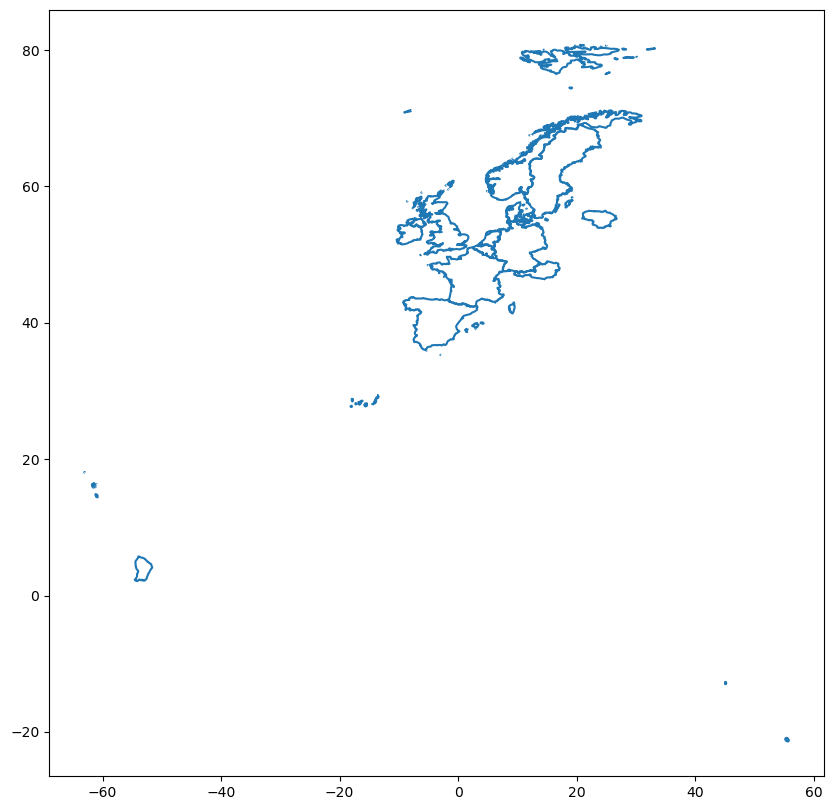

In [11]:
# Plot these shapes with different colors for each country
plt.figure(figsize=(10, 10))
ax = plt.axes()
NUTS_shapefile.boundary.plot(ax=ax)

(30.0, 80.0)

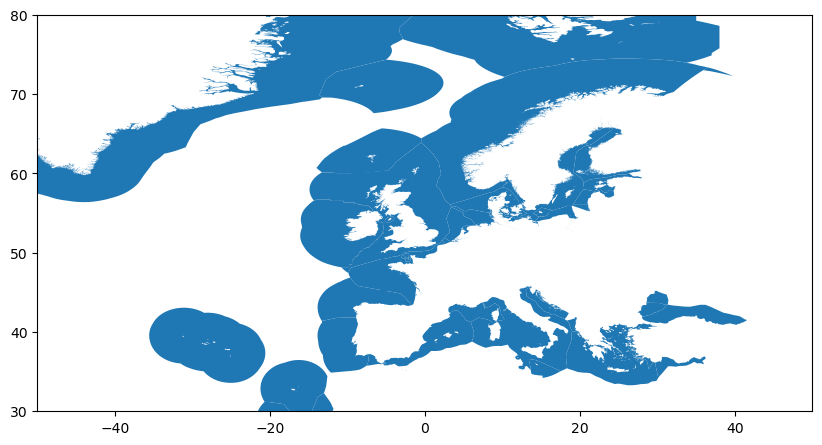

In [12]:
# PLot the eez shapes
plt.figure(figsize=(10, 10))
ax = plt.axes()
EEZ_shapefile.geometry.plot(ax=ax)
# Constrain to specific bounds
ax.set_xlim(-50, 50)
ax.set_ylim(30, 80)

Now we want to process the correlation data for the EEZ domains, then plot the strength of these correlations on the map.

In [3]:
# Import the functions
import functions_em as funcs

# Extract the data from the .nc file
eez_cfs = funcs.extract_offshore_eez_to_df(
    filepath=os.path.join(dicts.clearheads_dir, "EEZ_zones_wp_historical.nc")
)

ERROR 1: PROJ: proj_create_from_database: Open of /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/envs/jaspy3.10-mf-22.11.1-4-r20230718/share/proj failed


In [4]:
# Look at the head of the dataframe
eez_cfs.head()

,Spain_0,Norway_1,United Kingdom_2,Ireland_3,Finland_4,Sweden_5,Belgium_6,Netherlands_7,Germany_8,Denmark_9,...,Lithuania_15,Latvia_16,Croatia_17,Romania_18,Slovenia_19,Greece_20,Turkey_21,Malta_22,Albania_23,Bulgaria_24
time_in_hours_from_first_jan_1950,,,,,,,,,,,,,,,,,,,,,
1954-12-31,0.463322,0.589264,0.623401,0.650867,0.495598,0.499534,0.563498,0.585418,0.580573,0.568418,...,0.560168,0.550058,0.319417,0.458919,0.0,0.415682,0.375031,0.283086,0.315496,0.435560
1955-12-31,0.459715,0.598007,0.621849,0.647170,0.504291,0.502630,0.546857,0.573992,0.571843,0.560886,...,0.546895,0.543232,0.310311,0.454759,0.0,0.407107,0.370732,0.276836,0.309318,0.436682
1956-12-31,0.467224,0.597925,0.622789,0.650033,0.502469,0.503108,0.549734,0.576944,0.573917,0.561669,...,0.550026,0.547512,0.311823,0.452855,0.0,0.404924,0.369504,0.278412,0.309153,0.435956
1957-12-31,0.469298,0.596749,0.626987,0.655667,0.500476,0.501898,0.556206,0.585135,0.581586,0.567191,...,0.548471,0.545212,0.309431,0.436166,0.0,0.396006,0.359909,0.273056,0.303062,0.422619
1958-12-31,0.475237,0.592853,0.628979,0.660723,0.498298,0.505758,0.567372,0.592395,0.587245,0.575973,...,0.566914,0.561191,0.312364,0.433776,0.0,0.392068,0.356827,0.277860,0.311315,0.416827


In [14]:
import importlib

importlib.reload(funcs)

<module 'functions_em' from '/home/users/benhutch/energy-met-corr/functions_em.py'>

In [15]:
# test the other function for doing this
cfs = funcs.correlate_nao_uread(
    filename="EEZ_zones_wp_historical.nc",
)

NUTS_keys for UREAD data:  ['ES' 'NO' 'UK' 'IE' 'FI' 'SE' 'BE' 'NL' 'DE' 'DK' 'PO' 'FR' 'IT' 'PT'
 'EE' 'LI' 'LV' 'HR' 'RO' 'SI' 'GR' 'TR' 'MT' 'AL' 'BG']


In [16]:
cfs.head()

,ES,NO,UK,IE,FI,SE,BE,NL,DE,DK,...,LV,HR,RO,SI,GR,TR,MT,AL,BG,NAO anomaly (Pa)
1964-12-31,0.484011,0.588192,0.625989,0.680295,0.506070,0.504670,0.567749,0.583326,0.572031,0.562861,...,0.551736,0.317215,0.441299,0.0,0.383178,0.353909,0.277367,0.309614,0.418305,-459.190918
1965-12-31,0.485404,0.587854,0.623884,0.675909,0.505175,0.500834,0.564292,0.580379,0.567321,0.556950,...,0.552177,0.316208,0.445542,0.0,0.388816,0.358320,0.278524,0.310649,0.426743,-690.137828
1966-12-31,0.485558,0.585045,0.623956,0.674387,0.496668,0.491019,0.559140,0.577548,0.563846,0.549513,...,0.537800,0.312884,0.448921,0.0,0.392327,0.360686,0.279371,0.312071,0.431473,-668.218474
1967-12-31,0.481957,0.587782,0.627295,0.673570,0.501746,0.498297,0.565502,0.588240,0.576535,0.558334,...,0.546084,0.307474,0.447668,0.0,0.389807,0.358890,0.271839,0.307856,0.429846,-603.220347
1968-12-31,0.480453,0.593806,0.629429,0.669331,0.508093,0.503686,0.566467,0.591715,0.583839,0.569484,...,0.551089,0.308064,0.452348,0.0,0.391516,0.358720,0.274820,0.311600,0.434270,-487.312634


In [ ]:
# Load in the ERA5 data for the NAO index
# Use this file
# adaptor.mars.internal-1691509121.3261805-29348-4-3a487c76-fc7b-421f-b5be-7436e2eb78d7.nc
# in ~/ERA5/
# Load the dataset
era5_data_path = "~/ERA5/adaptor.mars.internal-1691509121.3261805-29348-4-3a487c76-fc7b-421f-b5be-7436e2eb78d7.nc"

# Load the data into chunks
ds_era5 = xr.open_mfdataset(
    era5_data_path,
    combine="by_coords",
    parallel=True,
    chunks={"time": 100, "latitude": 100, "longitude": 100},
)[
    "msl"
]  # for mean sea level pressure

# Combine the first two expver variables
obs_msl = ds_era5.sel(expver=1).combine_first(ds_era5.sel(expver=5))

In [ ]:
# Constrain obs to ONDJFM
obs_msl = obs_msl.sel(time=obs_msl.time.dt.month.isin([10, 11, 12, 1, 2, 3]))

# Shift the time index back by 3 months
obs_msl_shifted = obs_msl.shift(time=-3)

# Take annual means
obs_msl_annual = obs_msl_shifted.resample(time="Y").mean()

# Throw away years 1959, 2021, 2022 and 2023
obs_msl_annual = obs_msl_annual.sel(time=slice("1960", "2019"))

# Remove the climatology
obs_msl_anomaly = obs_msl_annual - obs_msl_annual.mean(dim="time")

In [ ]:
# Extract the lats and lons of the azores
lat1, lat2 = dicts.era5_azores["lat1"], dicts.era5_azores["lat2"]
lon1, lon2 = dicts.era5_azores["lon1"], dicts.era5_azores["lon2"]

# Calculate the mean for the azores gridbox
obs_msl_anomaly_azores = obs_msl_anomaly.sel(
    latitude=slice(lat1, lat2), longitude=slice(lon1, lon2)
).mean(dim=["latitude", "longitude"])

In [ ]:
# Same for iceland
lat1, lat2 = dicts.era5_iceland["lat1"], dicts.era5_iceland["lat2"]
lon1, lon2 = dicts.era5_iceland["lon1"], dicts.era5_iceland["lon2"]

# Calculate the mean for the iceland gridbox
obs_msl_anomaly_iceland = obs_msl_anomaly.sel(
    latitude=slice(lat1, lat2), longitude=slice(lon1, lon2)
).mean(dim=["latitude", "longitude"])

In [ ]:
# Calculate the NAO index (azores - iceland)
nao_index = obs_msl_anomaly_azores - obs_msl_anomaly_iceland

In [ ]:
# EXtract the time series
nao_index_time = nao_index.time.values

# Extract the values
nao_index_values = nao_index.values

# Create a dataframe
nao_df = pd.DataFrame({"time": nao_index_time, "value": nao_index_values})

# Take a centred 8-year running mean
nao_running = nao_df.set_index("time").rolling(8, center=True).mean()

In [ ]:
# Have a look at the dataframe
nao_running.head()

In [ ]:
# Drop the NaN values
nao_running = nao_running.dropna()

In [ ]:
# Combine the two dataframes into one, using the index of the first
eez_df = eez_cfs.join(nao_running, how="inner")

In [ ]:
eez_df.head()

In [ ]:
# Rename the value column as 'NAO anomaly (Pa)'
eez_df = eez_df.rename(columns={"value": "NAO anomaly (Pa)"})

In [ ]:
# Drop the rows which contain NaN values in the NAO anomaly column
eez_df = eez_df.dropna()

In [ ]:
eez_df.head()

In [ ]:
from scipy.stats import pearsonr
import pandas as pd

# Create a new dataframe with columns for:
# 'region' - e.g. Netherlands_7
# 'correlation' - the correlation between the NAO and the offshore wind CFs
# 'p-value' - the p-value of the correlation
# Set up the dataframe
correlation_df = pd.DataFrame(columns=["region", "correlation", "p-value"])

# Loop over the regions
for region in eez_df.columns[:-1]:
    # Calculate the correlation
    corr, p = pearsonr(eez_df[region], eez_df["NAO anomaly (Pa)"])

    # Create a new DataFrame to append
    df_to_append = pd.DataFrame(
        {"region": [region], "correlation": [corr], "p-value": [p]}
    )

    # Append to the dataframe
    correlation_df = pd.concat([correlation_df, df_to_append], ignore_index=True)

In [ ]:
correlation_df.head()

In [ ]:
# Remove the numbers from the region column by removing the last 2 characters
correlation_df["region"] = correlation_df["region"].str

In [ ]:
correlation_df

In [ ]:
# if any of the region names contain the string "_" then remove it
correlation_df["region"] = correlation_df["region"].str.replace("_", " ")

In [ ]:
correlation_df.head()

In [ ]:
EEZ_shapefile["SOVEREIGN1"]

In [ ]:
# Create two new columns in the geopandas dataframe 'EEZ_shapefile'
# 'correlation' - the correlation between the NAO and the offshore wind CFs
# 'p-value' - the p-value of the correlation
EEZ_shapefile["correlation"] = np.nan
EEZ_shapefile["p-value"] = np.nan

In [ ]:
EEZ_shapefile.head()

In [ ]:
# Loop over the regions in correlation_df
for region in correlation_df["region"]:
    # Extract the row from correlation_df
    row = correlation_df[correlation_df["region"] == region]

    # Extract the correlation and p-value
    corr = row["correlation"].values[0]
    p = row["p-value"].values[0]

    # Set the values in the EEZ_shapefile
    EEZ_shapefile.loc[EEZ_shapefile["TERRITORY1"] == region, "correlation"] = corr
    EEZ_shapefile.loc[EEZ_shapefile["TERRITORY1"] == region, "p-value"] = p

In [ ]:
EEZ_shapefile["TERRITORY1"] == "France", "correlation"

In [ ]:
# Extract the list of Terrirories
territories = EEZ_shapefile["TERRITORY1"]

# Convert to a list
territories = list(territories)

# Print the territories
print(territories)

In [ ]:
# Constrain EEZ shapefile to only include the territories in the list
EEZ_shapefile = EEZ_shapefile[EEZ_shapefile["TERRITORY1"].isin(dicts.countries_list)]

In [ ]:
# Print the correlation values for FRance
print(EEZ_shapefile[EEZ_shapefile["SOVEREIGN1"] == "France"]["correlation"])

In [ ]:
# Import cartopy
import cartopy.crs as ccrs

# Now plot the EEZ_shapefile with the correlation as the color
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
EEZ_shapefile.plot(column="correlation", ax=ax, legend=True, cmap="coolwarm")
# Use cartopy to add the coastlines
ax.coastlines()
# Make the colorbar smaller
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel("Correlation", fontsize=12)
cbar.tick_params(labelsize=10)

# Constrain to specific bounds
ax.set_xlim(-50, 50)
ax.set_ylim(30, 80)

In [ ]:
# Now plot the EEZ_shapefile with the correlation as the color
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})
cax = EEZ_shapefile.plot(
    column="correlation", ax=ax, cmap="coolwarm", add_colorbar=False
)

# Use cartopy to add the coastlines
ax.coastlines()

# Add colorbar
cbar = fig.colorbar(cax.collections[0], ax=ax, shrink=0.5)
cbar.set_label("Correlation")

# Constrain to specific bounds
ax.set_xlim(-50, 50)
ax.set_ylim(30, 80)